In [67]:
!pip install selenium
!pip install folium

     |████████████████████████████████| 102kB 6.7MB/s ta 0:00:011


# Import all required Libraries
from datetime import datetime
import numpy as np
import pandas as pd
import requests as req
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
#from selenium import webdriver
print("Loaded Modules at " + datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

In [2]:
#Build NYC dataset
path_ny = "https://cocl.us/new_york_dataset"
resp = req.get(path_ny).json()
features = resp['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
new_york_data = pd.DataFrame(columns=column_names)
for i in features:
    borough = i['properties']['borough']
    neighborhood_name = i['properties']['name']

    neighborhood_latlon = i['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]

    new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

print("New York Data Loaded " + datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
new_york_data.head()

New York Data Loaded 19/06/2020 02:13:52


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [3]:
new_york_data.groupby("Borough").count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


In [4]:
#This is not in use
df_ny_wiki_old = pd.read_html("https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City",header = 0)[0]
df_ny_wiki_old = pd.DataFrame(df_ny_wiki_old)
df_ny_wiki_old.head()

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
0,Bronx CB 1,7.17,91497,12761,"Melrose, Mott Haven, Port Morris"
1,Bronx CB 2,5.54,52246,9792,"Hunts Point, Longwood"
2,Bronx CB 3,4.07,79762,19598,"Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx CB 4,5.28,146441,27735,"Concourse, Highbridge"
4,Bronx CB 5,3.55,128200,36145,"Fordham, Morris Heights, Mount Hope, Universit..."


In [5]:
df_ny_wiki_old.tail()

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
55,Queens CB 14,23.28,106686,4583,"Arverne, Bayswater, Belle Harbor, Breezy Point..."
56,Staten Island CB 1,36.62,162609,4440,"Arlington, Castleton Corners, Clifton, Concord..."
57,Staten Island CB 2,54.62,127071,2326,"Arrochar, Bloomfield, Bulls Head, Chelsea, Don..."
58,Staten Island CB 3,58.97,152908,2593,"Annadale, Arden Heights, Bay Terrace, Charlest..."
59,New York City,831.39,8008278,9632,NaN


In [6]:
WIKI_LINK = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
ROOT_WIKI_LINK = "https://en.wikipedia.org"
page = req.get(WIKI_LINK)
soup = BeautifulSoup(page.text, 'html.parser')
population_list = []
for table_row in soup.select("table.wikitable tr"):
    cells = table_row.findAll('td')
    if len(cells) > 0:
        borough = cells[0].text.strip().replace('\xa0', ' ').split(' ')[0]
        population = int(cells[3].text.strip().replace(',', ''))
        for item in cells[4].findAll('a'):
            neighborhood = item.text
            neighbourhood_page = req.get(
                ROOT_WIKI_LINK+item['href'])
            soup = BeautifulSoup(
                neighbourhood_page.text, 'html.parser')
            table = soup.select("table.infobox tr")
            should_record = False
            for row in table:
                head = row.find('th')
                body = row.find('td')
                if head and 'population' in head.text.lower():
                    should_record = True
                    continue
                if should_record:
                    try:
                        population_list.append(
                            [borough, neighborhood, int(body.text.replace(',', ''))])
                    except:
                        pass
                    should_record = False
df_ny_wiki = pd.DataFrame(population_list, columns=[
                  "Borough", "Neighborhood", "Population"])

print("Wiki Population data loaded at " + datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
df_ny_wiki.head()

Wiki Population data loaded at 19/06/2020 02:16:27


,Borough,Neighborhood,Population
0,Bronx,Melrose,24913
1,Bronx,Mott Haven,52413
2,Bronx,Port Morris,3523
3,Bronx,Hunts Point,12281
4,Bronx,Longwood,26196


In [7]:
df_ny_wiki.tail()

,Borough,Neighborhood,Population
188,Staten,New Dorp,28225
189,Staten,Ocean Breeze,8575
190,Staten,South Beach,8575
191,Staten,Great Kills,40720
192,Staten,Tottenville,14945


In [8]:
# Join NYC Latitude / Longitude data with Wikipedia Population data
new_york_data.set_index('Neighborhood')
df_ny_wiki.set_index('Neighborhood')
nyc_df = pd.merge(new_york_data, df_ny_wiki, how="inner", on=["Borough", "Neighborhood"])
print("Wiki Population data loaded at " + datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
nyc_df.head()

Wiki Population data loaded at 19/06/2020 02:19:31


,Borough,Neighborhood,Latitude,Longitude,Population
0,Bronx,Wakefield,40.894705,-73.847201,29158
1,Bronx,Co-op City,40.874294,-73.829939,43752
2,Bronx,Fieldston,40.895437,-73.905643,3292
3,Bronx,Riverdale,40.890834,-73.912585,48049
4,Bronx,Kingsbridge,40.881687,-73.902818,10669


In [9]:
df_ny_wiki.groupby("Borough")["Neighborhood"].count()

Borough
Bronx        45
Brooklyn     45
Manhattan    33
Queens       58
Staten       12
Name: Neighborhood, dtype: int64

In [10]:
new_york_data.groupby("Borough")["Neighborhood"].count()

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

In [11]:
# Join NYC Latitude / Longitude data with Wikipedia Population data
'''new_york_data.set_index('Neighborhood')
df_ny_wiki.set_index('Neighborhood')
nyc_df = pd.merge(new_york_data, df_ny_wiki, how="outer", on=["Borough", "Neighborhood"])
print("Wiki Population data loaded at " + datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
nyc_df.dropna(0,how='any')
nyc_df.tail()'''

'new_york_data.set_index(\'Neighborhood\')\ndf_ny_wiki.set_index(\'Neighborhood\')\nnyc_df = pd.merge(new_york_data, df_ny_wiki, how="outer", on=["Borough", "Neighborhood"])\nprint("Wiki Population data loaded at " + datetime.now().strftime("%d/%m/%Y %H:%M:%S"))\nnyc_df.dropna(0,how=\'any\')\nnyc_df.tail()'

In [12]:
# Count of Neighborhood per Borough
nycnt_df =nyc_df.groupby("Borough")["Neighborhood"].count()
nycnt_df

Borough
Bronx        35
Brooklyn     41
Manhattan    25
Queens       50
Name: Neighborhood, dtype: int64

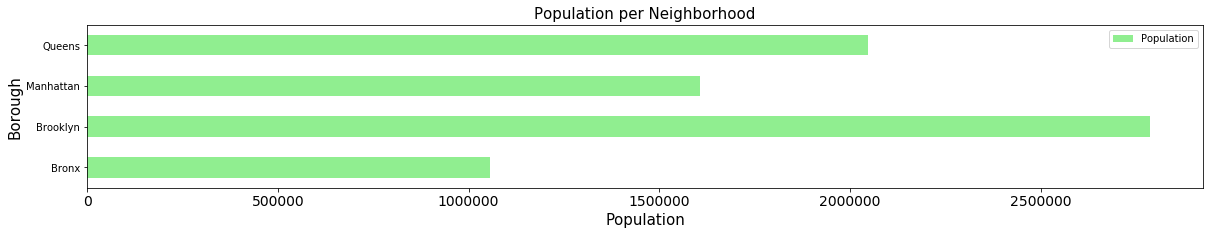

In [13]:
# Population by Borough
nycsum_df =nyc_df.groupby("Borough")["Population"].sum()
plt.figure(figsize=(20,3))
plt.title("Population per Neighborhood",fontsize=15)
plt.xlabel("Population", fontsize=15)
plt.ylabel("Borough", fontsize=15)
plt.xticks(fontsize=14)
ax= nycsum_df.plot(x="Population",y="Borough", kind='barh',legend='True',color='lightgreen')
plt.legend()
plt.show()

In [15]:
#### fetch hospital information for each Neighborhood
def get_hospital_data(lat, lng, borough, neighborhood):
    radius = 1000
    LIMIT = 100
    VERSION = '20200328'
    FS_CLIENT_ID = "1TXZ4UDMRBILKFHIYJ2QR2MOBDTRR3LVUVMS5CN5KRX3BKYV"
    FS_CLIENT_SECRET = "OCRXZJ3LRWH4PTDXGB0SVS2JJOFHJFNGAKWLWVMWK20BSJZM"
    FS_HOSPITAL_KEY = "4bf58dd8d48988d196941735"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FS_CLIENT_ID,
        FS_CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT,
        FS_HOSPITAL_KEY)
    response = req.get(url)
    if not response.status_code == 200:
        print("ERROR", response.status_code, response.content)
        return None
    results = response.json()
    venue_data = results["response"]["venues"]
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['id']
            venue_name = row['name']
            lat = row["location"]["lat"]
            lng = row["location"]["lng"]
            venue_details.append(
                [venue_id, venue_name, lat, lng, borough, neighborhood])
        except KeyError:
            pass

    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    df = pd.DataFrame(venue_details, columns=column_names)
    return df

In [16]:
# get hospital data
def get_hospital_per_neighborhood_borough(df):
    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    data = []
    for i, row in df.iterrows():
        h_df = get_hospital_data(
            row["Latitude"], row["Longitude"], row["Borough"], row["Neighborhood"])
        if h_df is not None:
            for x, hrow in h_df.iterrows():
                data.append([hrow[column] for column in column_names])

    n_df = pd.DataFrame(data, columns=column_names)
   # n_df.to_csv('hospital_per_boro_nei.csv')
    return n_df

In [18]:
# Fetch the Hospital data
hospital_df = get_hospital_per_neighborhood_borough(nyc_df)
hospital_df.head()

,ID,Name,Latitude,Longitude,Borough,Neighborhood
0,59832a7bfe37406ea7eb3a79,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870056,-73.828316,Bronx,Co-op City
1,50173409e4b0cfe38c43abf4,wellcare,40.874247,-73.837745,Bronx,Co-op City
2,568e86f5498ec6df53771448,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Bronx,Co-op City
3,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888119,-73.910217,Bronx,Fieldston
4,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888119,-73.910217,Bronx,Riverdale


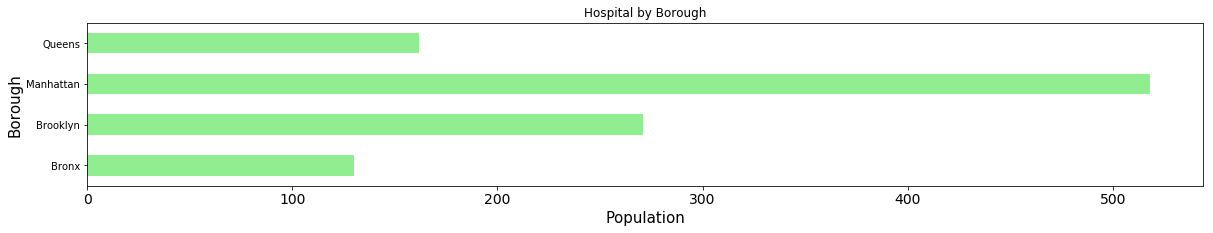

In [19]:
# Check the count the number of Hospital by Borough
hos_df =hospital_df.groupby("Borough")["Name"].count()
plt.figure(figsize=(20,3))
plt.title("Count of Neighborhood per Borough",fontsize=15)
plt.xlabel("Population", fontsize=15)
plt.ylabel("Borough", fontsize=15)
plt.xticks(fontsize=14)
hos_df.plot(kind="barh",title="Hospital by Borough",color='lightgreen',)

In [180]:
# Now let us fetch hospital bed data from NYS Health Profile
def get_bed_per_hospital():
    """
    Fetch data NYS Health Profile. A selenium based scrapper will be used  as it is a dynamic site. 
    A fixed list of IDs have been used for fetching data. These IDs are collected manualy from the website.
    In next phase I will try populate below ID real time.
    """
    ROOT_URL = "https://profiles.health.ny.gov/hospital/printview/{}"
    NYM_NYC = [
        103016, 106804, 102908, 103035, 102934, 1256608, 105117, 103009, 102974, 103006, 103041, 105086, 103056, 103086, 102973,
        102970, 102950, 103074, 103008, 103007, 102985, 103012, 106809, 102937, 103068, 102944, 102995, 106803, 102916, 105109,
        102914, 102960, 103038, 106810, 106811, 102961, 102940, 102933, 103078, 254693, 103065, 103021, 103080, 103033, 102919,
        105116, 106825, 103084, 103087, 102989, 102929, 106817, 106819, 103073, 103085, 103025
    ]  # New York Metro: New York City Hospitals' IDs 
    NYM_LI = [
        102999, 103062, 102928, 103002, 102980, 103077, 103049, 103011, 102918, 102965, 102994, 102966, 103069, 1189331, 102926,
        103088, 103045, 103000, 103070, 105137, 103082, 102954, 103072
    ] # New York Metro: Long Iceland Hospitals' IDs
    BRONX = [
        102908, 106804, 105117, 102973, 102950, 106809, 102937, 103068, 102944, 103078, 103087
    ] # New York Metro: Bronx Hospitals' IDs
    QUEENS = [
        102974, 103006, 102912, 103074, 103008, 105109, 102933, 103033, 103084
    ] # New York Metro: Queens Hospitals' IDs

    HOSPITALS = list(set(NYM_LI + NYM_NYC + BRONX + QUEENS))
    print('Total hospitals', len(HOSPITALS))

    hospital_data = []

    for val in HOSPITALS:
        print("Processing hospital id", val)
        url = ROOT_URL.format(val)
        browser = webdriver.Chrome()
        try:
            browser.get(url)
            time.sleep(10)
            html = browser.page_source
            soup = BeautifulSoup(html, 'html.parser')
            hospital_name = soup.find('h2').text
            table = soup.select("table", id="number-of-beds")[0]
            rows = table.findAll('tr')
            hospital_name = soup.find('h2').text.strip()
            icu_beds = 0
            for row in rows:
                tds = row.findAll('td')
                should_record = False
                for td in tds:
                    if "intensive care beds" == td.text.lower():
                        should_record = True
                        continue
                    if should_record:
                        icu_beds = td.text

            bed_number = rows[-1].findAll('td')[-1].text
            print(hospital_name, bed_number, icu_beds)
            hospital_data.append([hospital_name, bed_number, icu_beds])
        except Exception as e:
            print(e)
        browser.quit()
    df = pd.DataFrame(
        hospital_data, columns=[
            "Hospital Name", "Bed Number", "ICU Bed Number"
        ]
    )
    df = df.drop_duplicates(subset='Hospital Name', keep='last')
    df.to_csv('hospital_beds.csv')
    return df

In [20]:
# Invoke bed information
#hospital_bed_df = get_bed_per_hospital()
hospital_bed_path = "https://raw.githubusercontent.com/anandshaw214-source/appliedDataScience_Assignments/Neighborhoods/hospital_bed.csv"
#hospital_bed_df = pd.read_csv("hospital_bed.csv",index_col=0)
hospital_bed_df = pd.read_csv(hospital_bed_path,index_col=0,error_bad_lines=False)
hospital_bed_df.head()

,Bed Number,ICU Bed Number,Borough,Neighborhood
Hospital Name,,,,
Jamaica Hospital Medical Center,402,8,Queens,Briarwood
"New York Community Hospital of Brooklyn, Inc",134,7,Brooklyn,Fort Greene
Mount Sinai Hospital,1134,85,Manhattan,East Harlem
Nassau University Medical Center,530,22,Manhattan,Turtle Bay
Richmond University Medical Center,448,20,Manhattan,Turtle Bay


In [21]:
# Total bed count and icu per neighborhood and borough
total_bed_vs_icu = hospital_bed_df.groupby(["Neighborhood", "Borough"]).agg({"Bed Number": "sum","ICU Bed Number": "sum"})
total_bed_vs_icu.tail()

,,Bed Number,ICU Bed Number
Neighborhood,Borough,,
Upper East Side,Manhattan,632,15
Williamsburg,Brooklyn,69,0
Windsor Terrace,Brooklyn,839,40
Woodlawn,Bronx,321,16
Yorkville,Manhattan,1438,103


In [23]:
# Total bed count vs icu per borough
total_bed_v_icu_b = hospital_bed_df.groupby([ "Borough"]).agg({"Bed Number": "sum","ICU Bed Number": "sum"})
total_bed_v_icu_b.tail()

,Bed Number,ICU Bed Number
Borough,,
Bronx,5041,281
Brooklyn,7168,461
Manhattan,12266,808
Queens,3902,201


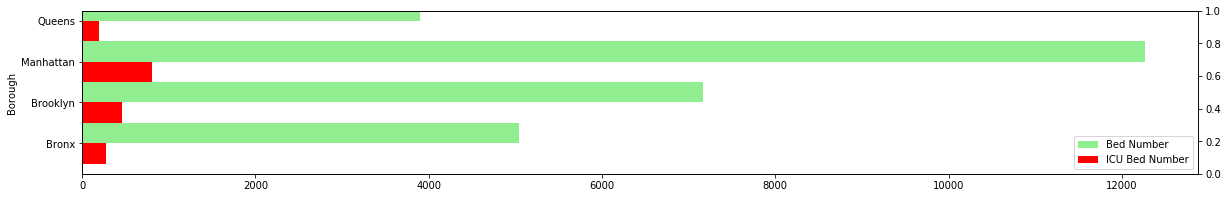

In [24]:
fig = plt.figure(figsize=(20,3)) 

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
total_bed_v_icu_b["Bed Number"].plot(kind='barh', color='lightgreen', ax=ax,  position=0,legend=True)
total_bed_v_icu_b["ICU Bed Number"].plot(kind='barh', color='red', ax=ax,  position=1,legend=True)
plt.show()

In [47]:
df = pd.merge(total_bed_vs_icu, nyc_df, how="inner", on=["Borough", "Neighborhood"])
df.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population
0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705
1,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705
2,Queens,Briarwood,671,24,40.710935,-73.811748,53877
3,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547
4,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300


In [48]:
# Get Bed per hundred person
def get_bed_per_hunderd_person(row, field="Bed Number"):
    return row[field] * 100 / row["Population"]

df["Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row), axis=1)

df["ICU Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row, field="ICU Bed Number"), axis=1)

df.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,Bed Per Hundred People,ICU Bed Per Hundred People
0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.134472,0.005273
1,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.134472,0.005273
2,Queens,Briarwood,671,24,40.710935,-73.811748,53877,1.245429,0.044546
3,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.860832,0.047824
4,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,1.029160,0.048027


In [49]:
# New df for k-means clustring
df_clusters = df.drop(['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'ICU Bed Number', 'Bed Number'],axis = 1)
df_clusters.head()

,Population,Bed Per Hundred People,ICU Bed Per Hundred People
0,151705,0.134472,0.005273
1,151705,0.134472,0.005273
2,53877,1.245429,0.044546
3,35547,0.860832,0.047824
4,58300,1.029160,0.048027


In [50]:
import sklearn
from sklearn.cluster import KMeans
def plot_kmeans(dataset):
    obs = dataset.copy()
    silhouette_score_values = list()
    number_of_clusters = range(3, 30)
    for i in number_of_clusters:
        classifier = KMeans(i, init='k-means++', n_init=10,
                            max_iter=300, tol=0.0001, random_state=10)
        classifier.fit(obs)
        labels = classifier.predict(obs)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(
            obs, labels, metric='euclidean', random_state=0))

    plt.plot(number_of_clusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()

    optimum_number_of_components = number_of_clusters[silhouette_score_values.index(
        max(silhouette_score_values))]
    print("Optimal number of components is:")
    print(optimum_number_of_components)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


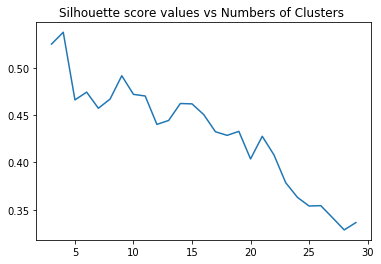

Optimal number of components is:
4


In [51]:
df_clusters = sklearn.preprocessing.StandardScaler().fit_transform(df_clusters)
df_clusters
plot_kmeans(df_clusters)

In [44]:
# Optimal number of components is: 4
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:24]

array([0, 0, 1, 1, 1, 0, 3, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 3,
       1, 1], dtype=int32)

In [52]:
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,Bed Per Hundred People,ICU Bed Per Hundred People
0,0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.134472,0.005273
1,0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.134472,0.005273
2,1,Queens,Briarwood,671,24,40.710935,-73.811748,53877,1.245429,0.044546
3,1,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.860832,0.047824
4,1,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,1.029160,0.048027


In [35]:
df.drop_duplicates()

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,Bed Per Hundred People,ICU Bed Per Hundred People
0,0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.134472,0.005273
2,1,Queens,Briarwood,671,24,40.710935,-73.811748,53877,1.245429,0.044546
3,1,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.860832,0.047824
4,1,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,1.029160,0.048027
5,0,Brooklyn,Bushwick,324,16,40.698116,-73.925258,129239,0.250698,0.012380
6,3,Brooklyn,Carroll Gardens,535,29,40.680540,-73.994654,12853,4.162452,0.225628
7,1,Manhattan,Chelsea,212,12,40.744035,-74.003116,47325,0.447966,0.025357
8,1,Manhattan,Chinatown,180,13,40.715618,-73.994279,47844,0.376223,0.027172
10,1,Manhattan,Clinton,296,12,40.759101,-73.996119,45884,0.645105,0.026153
11,0,Brooklyn,Crown Heights,287,13,40.670829,-73.943291,143000,0.200699,0.009091


In [59]:
def get_geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        return [latitude, longitude]
    return [None, None]

In [76]:
def save_map(m, filepath='map.html'):
    m.save(filepath)

def render_map_clusters(df, df_clusters, bpp_df=df_clusters[:, 1],kclusters=3, m_boost=5, add_boost=5):
    map_clusters = folium.Map(
        location=get_geo_location("New York"), zoom_start=11)
    colours = ['red', 'black', 'blue']
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    markers_colors = []
    for lat, lon, poi, nei, cluster, bed_per_people in zip(df['Latitude'], df['Longitude'], df['Borough'], df["Neighborhood"], df['Cluster Labels'], bpp_df):
        label = folium.Popup(
            ' Cluster ' + str(cluster)+': ' + str(poi) + "-" + str(nei),
            parse_html=True
        )
        folium.CircleMarker(
            [lat, lon],
            radius=bed_per_people*m_boost+add_boost,
            popup=label,
            color=colours[cluster],
            fill=True,
            fill_color=colours[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

In [119]:
# Testing. This block not in use
map_clusters = folium.Map(location=get_geo_location("New York"), zoom_start=11)
colours = ['red', 'black', 'blue']
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
bpp_df=df_clusters[:, 1]
folium.CircleMarker(
            [40.57682506566604, -73.96509448785336 ],
            radius=10,
            popup=label,
            color=colours[cluster],
            fill=True,
            fill_color=colours[cluster])

In [128]:
# Render the map
map_clusters = render_map_clusters(df, df_clusters)
map_clusters
#save_map(map_clusters)

In [130]:
# Render the map for bed per 100 people
map_clusters = render_map_clusters(df, df_clusters,df['Bed Per Hundred People'],m_boost=1,add_boost=5)
map_clusters
#save_map(map_clusters, 'bed_per_hundred.html')

In [131]:
# Now let us render the map for ICU bed per 100 people
map_clusters = render_map_clusters(df, df_clusters,df['ICU Bed Per Hundred People'],m_boost=2,add_boost=5)
map_clusters
#save_map(map_clusters, 'icu_bed_per_hundred.html')

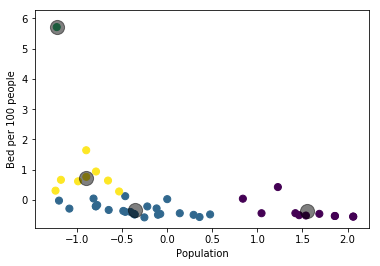

In [132]:
# Now we are going to use scatter plot

y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('Population')
plt.ylabel('Bed per 100 people')
plt.show()

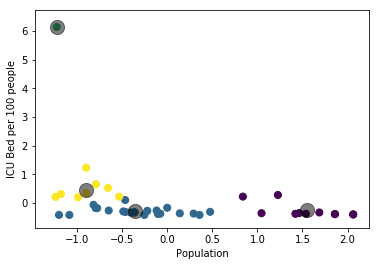

In [134]:
# Scatter plot for ICU bed per person

y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);
plt.xlabel('Population')
plt.ylabel('ICU Bed per 100 people')
plt.show()

In [137]:
df[(df['Cluster Labels'] == 3)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,Bed Per Hundred People,ICU Bed Per Hundred People
6,3,Brooklyn,Carroll Gardens,535,29,40.680540,-73.994654,12853,4.162452,0.225628
21,3,Queens,Glen Oaks,1497,98,40.749441,-73.715481,29506,5.073544,0.332136
26,3,Bronx,Melrose,1118,59,40.819754,-73.909422,24913,4.487617,0.236824
29,3,Bronx,Norwood,1169,80,40.877224,-73.879391,40494,2.886847,0.197560
36,3,Bronx,Spuyten Duyvil,306,20,40.881395,-73.917190,10279,2.976943,0.194571
38,3,Manhattan,Turtle Bay,1840,127,40.752042,-73.967708,24856,7.402639,0.510943
41,3,Brooklyn,Windsor Terrace,839,40,40.656946,-73.980073,20988,3.997522,0.190585
43,3,Manhattan,Yorkville,1438,103,40.775930,-73.947118,35221,4.082792,0.292439
